<a href="https://colab.research.google.com/github/ALM23/IRIC_preinterview/blob/main/IFT6390_H23_Devoir_2_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADequation: l'adéquation des connaissances en AD avec la pratique

Nous allons développer dans ce devoir un outil de différentiation automatique qui reproduit l'essence des outils plus sophistiqués comme Autograd et JAX. Nous allons y parvenir à l'aide d'un "traceur" qui nous permettra de constuire un graphe de calcul de manière dynamique. Nous allons ensuite pouvoir utiliser ce graph de calcul pour implémenter l'accumulation arrière de manière récursive.   

In [ ]:
import functools
import numpy as onp
import networkx as nx
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

In [ ]:
%config InlineBackend.figure_format = 'svg'

# Visualisation

Le code suivant sert à des fins de visualisation. Vous n'avez rien à implémenter vous-même ici. 

La fonction ``draw_computation_graph`` dessine le graphe de calcul à l'aide de la bibliothèque NetworkX et Matplotlib, et sauvegarde l'image dans un fichier PDF. La fonction ``convert_to_networkx`` convertit le graphe de calcul construit lors du traçage en partant du dernier nœud, et en visitant le graphe d'origine récursivement tout en ajoutant simultanément les nœuds et arêtes dans un graphe NetworkX.

In [ ]:
def draw_computation_graph(graph, scale=20.):
  pos = nx.multipartite_layout(graph, subset_key="layer", scale=scale)
  options = {"edgecolors": "tab:gray", "node_size": 3000, "alpha": 0.9, "node_color":"tab:red", "font_color":"tan", "font_size": 12}
  fig, ax = plt.subplots(figsize=(5,4))
  ax.set_ylim(-10, 10)
  nx.draw(graph, ax=ax, pos=pos, connectionstyle='arc3, rad = 0.5', with_labels=True, **options)
  ax.set_title("Computation Graph")
  fig.tight_layout()
  fig.savefig('graph.pdf')

def convert_to_networkx(node):
  def add_node(graph, node):
    if isinstance(node, onp.ndarray):
      node = Node(value=node) # because numpy.ndarray is not hashable
    graph.add_node(node)
    if hasattr(node, 'parents'):
      for p in node.parents:
        if isinstance(p, onp.ndarray):
          p = Node(value=p) # hashing
        graph.add_edge(p, node)
        graph = add_node(graph, p)
    return graph
      
  graph = nx.MultiDiGraph()
  graph = add_node(graph, node)

  for layer, nodes in enumerate(reversed(list(nx.topological_generations(graph)))):
    for node in nodes:
      graph.nodes[node]["layer"] = layer
  return graph

# Partie 1: traçage du code

Cette classe est utilisée pour représenter les nœuds dans le graphe de calcul de la différentiation automatique en mode inverse. Les parents sont les nœuds qui ont contribué à la valeur actuelle de ce nœud, la valeur est la valeur calculée pour ce nœud, et la fonction est la fonction qui a été utilisée pour calculer cette valeur. Le code suivant est un composant clé de notre implémentation et permet de construire le graphe de calcul dynamiquement. 

In [ ]:
class Node:
  def __init__(self, parents=[], value=None, func=None):
    self.parents = parents
    self.value = value
    self.func = func

  def __add__(self, other_node):
    return ad.add(self, other_node)

  def __sub__(self, other_node):
    return ad.subtract(self, other_node)

  def __mul__(self, other_node):
    return ad.multiply(self, other_node)

  def __pow__(self, other_node):
    return ad.power(self, other_node)
    
  def __str__(self):
    label = str(self.value) if self.func is None else str(self.func.__name__)
    return label

  def __repr__(self):
    return '<Node value=' + repr(self.value) + ', parents=' + repr(self.parents) + ', func=' + repr(self.func) + '>'

La fonction ``unbox`` prend une liste d'arguments et renvoie une nouvelle liste où chaque argument est remplacé par sa valeur s'il s'agit d'un objet ``Node``, ou laissé inchangé s'il ne l'est pas. Ce code sert donc à extraire les arguments enveloppés précédemment et de manipuler les objets d'origines directement. Nous allons utiliser cette fonction à chaque fois qu'une fonction tracée (décorée) est appelée pour développer (``unbox``) les arguments avant de les passer à la fonction d'origine (qui ne sait pas comment manipuler le type ``Node`` défini dans notre code). 

In [ ]:
def unbox(args):
  # À IMPLÉMENTER
  pass

La fonction ``trace`` prend une fonction ``func`` et une list de fonction ``vjp`` pour chaque argument. Elle renvoie une nouvelle fonction ``traced`` qui enveloppe ``func`` et renvoie un objet ``Node`` contenant la valeur calculée, les arguments d'origine et la fonction d'origine en tant qu'attributs. Lorsque le décorateur ``trace`` est appliqué sur une fonction primitive enveloppée, le dictionnaire  ``primitives`` est mis à jour avec ``func`` (clé) et son ``vjp``  correspondant (comme valeur pour la clé). Puisque nous allons supporter des primitives prenant plusieurs arguments, l'argument ``vjp`` doit être une liste de fonctions pour calculer la dérivée partielle de chaque argument.

## Définition des vjps

Nous pouvons maintenant définir un ensemble de primitives que nous souhaitons supporter dans notre système de différentiation automatique. Chaque fonction est décorée avec la fonction ``trace``, qui permet de tracer la fonction et d'ensuite appliquer la fonction de produit vecteur-Jacobien (vjp) correspondante lors de l'accumulation arrière. Nous stockons nos vjps dans un classe ``Adequation`` de manière à pouvoir dynamiquement changer l'espace de noms entre notre propre système de différentiation automatique et celui de JAX, pour des fins de vérifications. 

Définissez maintenant vous-même le vjp correspondant à la fonction ``numpy.dot``. Pour y arriver, notons que cette fonction est mathématiquement parlant, une fonction binaire de la forme $f(a, b) = a^\top b$ si $a$ et $b$ sont des vecteurs ou $f(A, B) = A B$ si $A$ et $B$ sont des matrices. 

In [ ]:
class Adequation():

  primitives = {}

  def trace(self, func, vjp):
    @functools.wraps(func)
    def traced(*args):
      # À IMPLÉMENTER
      pass 
    # À IMPLÉMENTER
    return traced

  def __init__(self):
    self.add = self.trace(onp.add, vjp=(lambda g, ans, x, y: g, 
                              lambda g, ans, x, y: g))
    self.subtract = self.trace(onp.subtract, vjp=(lambda g, ans, x, y: g, 
                                        lambda g, ans, x, y: -g))
    self.multiply = self.trace(onp.multiply, vjp=(lambda g, ans, x, y: y*g, 
                                        lambda g, ans, x, y: x*g))
    self.negative = self.trace(onp.negative, vjp=(lambda g, ans, x: -g,))
    self.exp = self.trace(onp.exp, vjp=(lambda g, ans, x: ans * g,))
    self.sin = self.trace(onp.sin, vjp=(lambda g, ans, x: g*onp.cos(x),))
    self.cos = self.trace(onp.cos, vjp=(lambda g, ans, x: -g*onp.sin(x),))
    self.power = self.trace(onp.power, 
                       vjp=(lambda g, ans, x, y : g * y * x ** onp.where(y, y - 1, 1.),
                            lambda g, ans, x, y : g * onp.log(onp.where(x, x, 1.)) * ans))

    self.dot = self.trace(onp.dot, vjp=(lambda g, ans, a, b: onp.dot(g, onp.transpose(b)), lambda g, ans, a, b: onp.dot(onp.transpose(a), g)))

Passons maintenant à l'espace de nom de notre implémentation:

In [ ]:
ad = Adequation()

## Exemples

Nous supportons la construction de graphe de calcul opérant autant sur des scalaires que des ``numpy.ndarray``



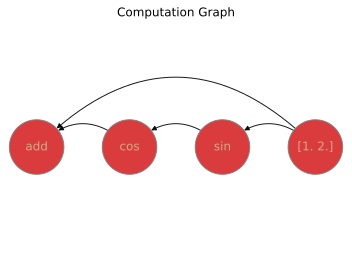

In [ ]:
def f(x):
  return ad.add(ad.cos(ad.sin(x)), x)
end_node = f(Node(value=onp.array([1., 2.])))
draw_computation_graph(convert_to_networkx(end_node))

À des fins esthétiques, nous pouvons également surcharger les opérateurs $+$, $-$, $*$ et $**$ en python pour appeler nos fonctions enveloppées correspondantes. Note: la classe ``Node`` utilise l'espace de nom ``ad``.

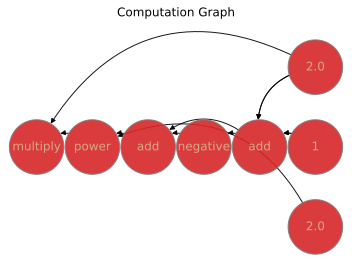

In [ ]:
def f(x):
  x1 = x + 1
  x2 = ad.negative(x1)
  x3 = ad.add(x1, x2)
  x4 = x3**2.
  return x * x4
end_node = f(Node(value=2.))
draw_computation_graph(convert_to_networkx(end_node))

Sans avoir fait quoi que ce soit de spécial, nous pouvons déjà supporter les boucles et conditions puisque celle-ci sont "aplaties" automatiquement lorsque de l'exécution du graphe de calcul. 

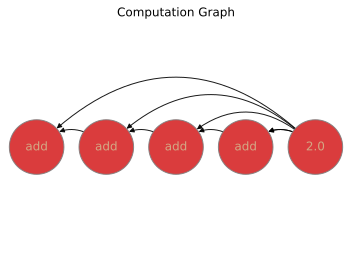

In [ ]:
def f(x):
  a = x
  for i in range(5):
    if i != 3:
      a = a + x
  return a
end_node = f(Node(value=2.))
draw_computation_graph(convert_to_networkx(end_node), scale=1e1)  

# Partie 2: accumulation arrière explicite

Parcourez le graph de calcul en ordre topologique inversé en propageant le vecteur adjoint, à partir d'un vecteur graine, à l'aide des opérations vjp. En présence de chemins multiples, sommez les vecteurs adjoints. 

Vous pouvez implémenter cette fonction avec une boucle et une pile (stack) si vous le souhaitez, ou bien de manière récursive comme décrite ici. La fonction ``visit`` suivante est conçue pour être appelée à partir de ``end_node`` avec le vecteur graine. La récursion se poursuit jusqu'au moment où nous atteignons un nœud de source (sans parents) et retournons le vecteur adjoint reçu sans modification. En visitant chaque nœud, nous prenons la somme des vecteurs adjoints calculés récursivement dans la branche correspondant à chaque argument. Avant de descendre dans une branche, il est nécessaire de s'assurer que l'argument est bien de type ``Node``. Si ce n'est pas le cas, cela signifie que l'argument ne dépend pas de la variable de différentiation, et ne doit donc pas entrer dans le calcul de la somme de la dérivée totale. 

In [ ]:
def visit(g, node):
  # À IMPLÉMENTER
  pass

Afin de pouvoir ensemencer notre accumulation arrière, nous devoir fournir un vecteur graine provenant d'une base standard. Nous reprenons ici la fonction correspondant définie dans le code d'autograd, qui nous permet de générer les éléments de cette base pour des espaces tensoriels. 

In [ ]:
def standard_basis(shape):
  for idxs in onp.ndindex(*shape):
      vect = onp.zeros(shape)
      vect[idxs] = 1
      yield vect

## Premier test: opération scalaire

Pour commencer, testons une fonction simple $f(x) =  \sin(x^2)$ où $x$ est un scalaire. La dérivée est alors $f'(x) = 2\cos(x^2)x$

In [ ]:
def f(x):
  return ad.sin(ad.power(x, 2.))

x = 1.
end_node = f(Node(value=x))
visit(1., end_node)

1.0806046117362795

Nous pouvons vérifier que nous obtenions la même solution que la dérivée analytique:

In [ ]:
2.*onp.cos(x**2.)

1.0806046117362795

## Deuxième test: produit scalaire

Tentons maintenant d'appliquer notre système à des vecteurs, pour le produit scalaire $f(x) = x^\top x$, $Df(x) = 2x^\top$

In [ ]:
def f(x):
  return ad.dot(x, x)

x = onp.array([2, 3.])
end_node = f(Node(value=x))
visit(1., end_node)

array([4., 6.])

## Troisième test: produit matriciel

Cette fois-ci, nous considérons un produit matriciel de la forme $f(A, B) = A B$. La base standard est maintenant plus complexe, tel que nous allons voir ci-dessous. 

In [ ]:
def f(x):
  return ad.dot(x, x)
x = onp.array([[1, 2.],[3,4]])
end_node = f(Node(value=x))
onp.reshape(onp.stack([visit(g, end_node) for g in standard_basis((2,2))]), (2, 2, 2, 2))

array([[[[2., 3.],
         [2., 0.]],

        [[2., 5.],
         [0., 2.]]],


       [[[3., 0.],
         [5., 3.]],

        [[0., 3.],
         [2., 8.]]]])

Comparons maintenant avec JAX en passant à l'espace de nom de jax plutôt que de notre implémentation. 

In [ ]:
ad = jax.numpy
jax.jacobian(lambda x: jnp.dot(x, x))(x)

DeviceArray([[[[2., 3.],
               [2., 0.]],

              [[2., 5.],
               [0., 2.]]],


             [[[3., 0.],
               [5., 3.]],

              [[0., 3.],
               [2., 8.]]]], dtype=float32)

# Partie 4: application en optimisation

Nous allons maintenant tenter de minimiser la fonction $f(x) = x^2$ par descente de gradient (déterminisite).

In [ ]:
ad = Adequation()

In [ ]:
def f(x):
  return x**2.

In [ ]:
x = 0.5
for _ in range(100):
  end_node = f(Node(value=x))
  print(x)
  grad = visit(1., end_node)
  x = x - 1e-1*grad

0.5
0.4
0.32
0.256
0.2048
0.16384
0.13107200000000002
0.10485760000000002
0.08388608000000002
0.06710886400000002
0.053687091200000016
0.04294967296000001
0.034359738368000006
0.027487790694400004
0.021990232555520003
0.017592186044416
0.014073748835532801
0.01125899906842624
0.009007199254740993
0.007205759403792794
0.005764607523034235
0.004611686018427388
0.0036893488147419105
0.0029514790517935286
0.002361183241434823
0.0018889465931478584
0.0015111572745182867
0.0012089258196146294
0.0009671406556917035
0.0007737125245533628
0.0006189700196426903
0.0004951760157141523
0.0003961408125713218
0.0003169126500570575
0.00025353012004564597
0.0002028240960365168
0.00016225927682921344
0.00012980742146337075
0.0001038459371706966
8.307674973655728e-05
6.646139978924582e-05
5.3169119831396656e-05
4.253529586511732e-05
3.4028236692093856e-05
2.7222589353675086e-05
2.1778071482940068e-05
1.7422457186352053e-05
1.3937965749081642e-05
1.1150372599265315e-05
8.920298079412252e-06
7.136238463529

## Deuxième application: régression linéaire 

Considérons maintenant un problème de régression linéaire.

In [ ]:
x = onp.linspace(0, 10, 100)
y = 2.*x + onp.random.normal(0, 1, 100)

Implémentons maintenant l'erreur quadratique moyenne. 

In [ ]:
def loss(w, x, y):
  # À IMPLÉMENTER
  pass

La procédure de descent de gradient suivante devrait pouvoir retrouver le coefficient d'origine de la droite d'origine. 

Text(0, 0.5, 'MSE')

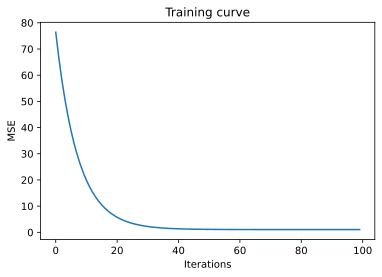

In [ ]:
w = 0.5
niter = 100
errors = onp.zeros((niter))
for i in range(niter):
  end_node = loss(Node(value=w), x, y)
  grad = visit(1., end_node)
  w = w - 1e-3*grad
  errors[i] = end_node.value
plt.plot(errors)
plt.title('Training curve')
plt.xlabel('Iterations')
plt.ylabel('MSE')

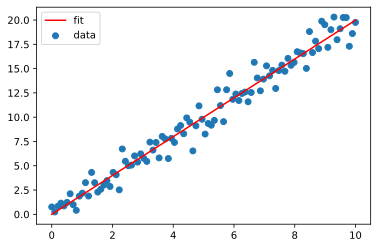

In [ ]:
plt.plot(x, onp.dot(x, w), c='r')
plt.scatter(x, y)
plt.legend(['fit', 'data'])

# Partie 5: extensions

Soit une fonction à plusieurs arguments de la forme $f(x, y, z)$. Expliquez comment nous pouvons utiliser l'approche développée ici pour calculer la dérivée partielle de cette fonction par rapport à tout argument, autre que seulement le premier, ou bien au-delà des fonctions à un seul argument de la forme $f(x)$. Tous les morceaux devraient être en place sans avoir à changer quoique ce soit dans ``trace`` ou ``visit`` pour y arriver. Il suffit ici de généraliser les étapes manuelles d'appel à ``visit`` et de création de bases standard à l'aide de ``standard_basis``.

Maintenant, implémentez une fonction ``grad`` permet de calculer le gradient d'une fonction par rapport à un argument donné ``argnum``.

In [ ]:
def jacobian(func, argnum):
  def jacfun(*primals):
      # À IMPLÉMENTER
    pass
  return jacfun

Proposez un exemple pour vérifier votre réponse. 

In [ ]:
# À IMPLÉMENTER